In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
# from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime

In [2]:
iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats_mpgrid/celltrack_stats/'
os.makedirs(figdir, exist_ok=True)

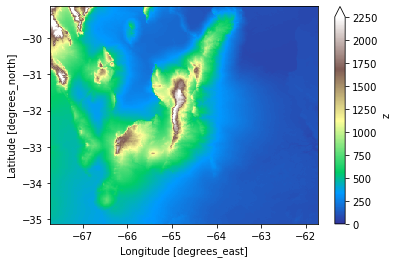

In [3]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [4]:
stats = xr.open_dataset(stats_file)
stats

<xarray.Dataset>
Dimensions:                  (times: 60, tracks: 6882)
Coordinates:
  * tracks                   (tracks) int32 0 1 2 3 4 ... 6878 6879 6880 6881
  * times                    (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables:
    lifetime                 (tracks) float64 ...
    basetime                 (tracks, times) datetime64[ns] ...
    core_meanlat             (tracks, times) float32 ...
    core_meanlon             (tracks, times) float32 ...
    core_mean_y              (tracks, times) float32 ...
    core_mean_x              (tracks, times) float32 ...
    cell_meanlat             (tracks, times) float32 ...
    cell_meanlon             (tracks, times) float32 ...
    cell_mean_y              (tracks, times) float32 ...
    cell_mean_x              (tracks, times) float32 ...
    cell_minlat              (tracks, times) float32 ...
    cell_minlon              (tracks, times) float32 ...
    cell_maxlat              (tracks, times) float32 ...
    cell_maxlon              (tracks, times) float32 ...
    cell_min_y               (tracks, times) float32 ...
    cell_min_x               (tracks, times) float32 ...
    cell_max_y               (tracks, times) float32 ...
    cell_max_x               (tracks, times) float32 ...
    dilatecell_meanlat       (tracks, times) float32 ...
    dilatecell_meanlon       (tracks, times) float32 ...
    dilatecell_mean_y        (tracks, times) float32 ...
    dilatecell_mean_x        (tracks, times) float32 ...
    core_radius              (tracks, times) float32 ...
    cell_radius              (tracks, times) float32 ...
    core_area                (tracks, times) float32 ...
    cell_area                (tracks, times) float32 ...
    maxdbz                   (tracks, times) float32 ...
    maxETH_10dbz             (tracks, times) float32 ...
    maxETH_20dbz             (tracks, times) float32 ...
    maxETH_30dbz             (tracks, times) float32 ...
    maxETH_40dbz             (tracks, times) float32 ...
    maxETH_50dbz             (tracks, times) float32 ...
    cloudnumber              (tracks, times) float64 ...
    status                   (tracks, times) float64 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_tracknumber  (tracks) float64 ...
    start_split_timeindex    (tracks) float64 ...
    start_split_cloudnumber  (tracks) float64 ...
    end_merge_tracknumber    (tracks) float64 ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
    merge_tracknumbers       (tracks, times) float64 ...
    split_tracknumbers       (tracks, times) float64 ...
    trackinterruptions       (tracks) float64 ...
    maxrange_flag            (tracks, times) float64 ...
Attributes:
    title:                 File containing statistics for each track
    Institution:           Pacific Northwest National Laboratoy
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Thu Jan 28 23:39:56 2021
    source:                CSAPR2
    description:           COR
    startdate:             20181015.0000
    enddate:               20190303.0000
    track_version:         v1.0
    tracknumbers_version:  v1.0
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       0.5

In [5]:
time_res = stats.attrs['time_resolution_hour']
time_res

0.25

In [6]:
tracks = stats['tracks']
times = stats['times']

lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [7]:
stats.sizes

Frozen(SortedKeysDict({'tracks': 6882, 'times': 60}))

In [8]:
# Get cell initial location
cell_lon0 = cell_lon.isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

Number of valid tracks: 6874


In [9]:
# Subset tracks
lifetime = lifetime.isel(tracks=ind)
start_time = start_time.isel(tracks=ind)
end_time = end_time.isel(tracks=ind)
end_merge_tracknumber = end_merge_tracknumber.isel(tracks=ind)
start_split_tracknumber = start_split_tracknumber.isel(tracks=ind)
cell_lon = cell_lon.isel(tracks=ind)
cell_lat = cell_lat.isel(tracks=ind)
cell_area = cell_area.isel(tracks=ind)
maxrange_flag = maxrange_flag.isel(tracks=ind)
eth10 = eth10.isel(tracks=ind)
eth20 = eth20.isel(tracks=ind)
eth30 = eth30.isel(tracks=ind)
eth40 = eth40.isel(tracks=ind)
eth50 = eth50.isel(tracks=ind)

In [10]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

(array([ 865.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6009.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

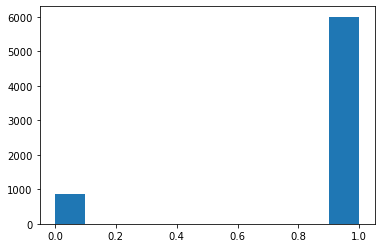

In [11]:
plt.hist(end_maxrange_flag, bins=np.arange(0,1.01,0.1))

In [12]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

In [13]:
# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

Number of non-merge tracks: 5250
Number of non-split tracks: 5314


In [14]:
nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

Number of non-split tracks within max range: 4817
Number of non-merge tracks within max range: 4504


In [15]:
merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of merge tracks: 1624
Number of split tracks: 1560


In [16]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)
hist_starthour, bins = np.histogram(start_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

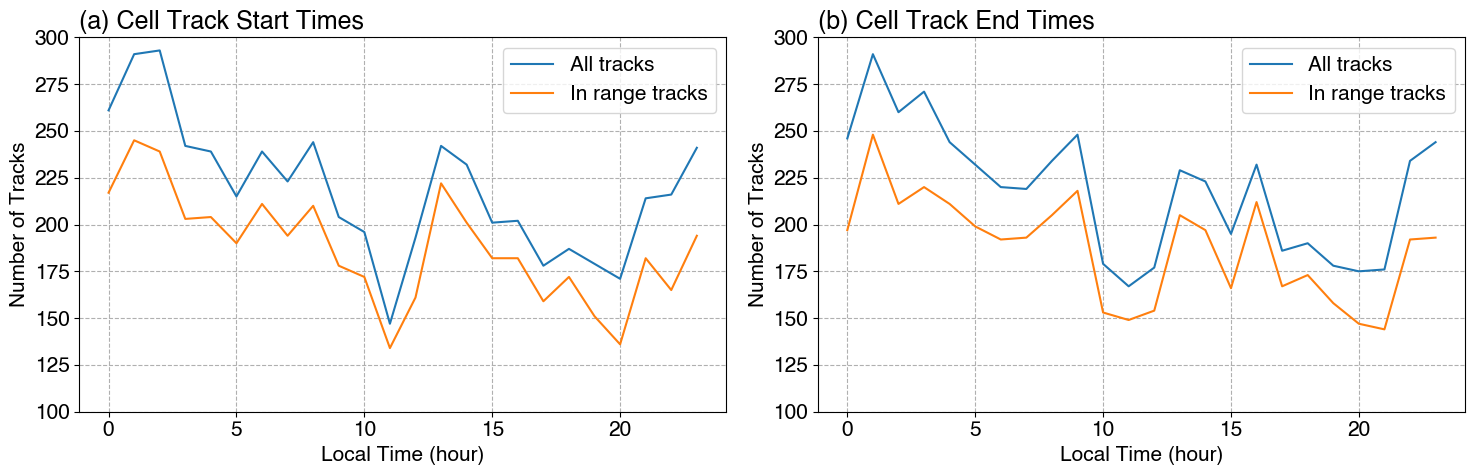

In [17]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

ax1 = axes[0]
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
ax1.legend()
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Start Times', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylim(100, 300)

ax2 = axes[1]
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
ax2.legend()
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track End Times', loc='left')
ax2.set_ylabel('Number of Tracks')
ax2.set_xlabel('Local Time (hour)')
ax2.set_ylim(100, 300)

fig.tight_layout()

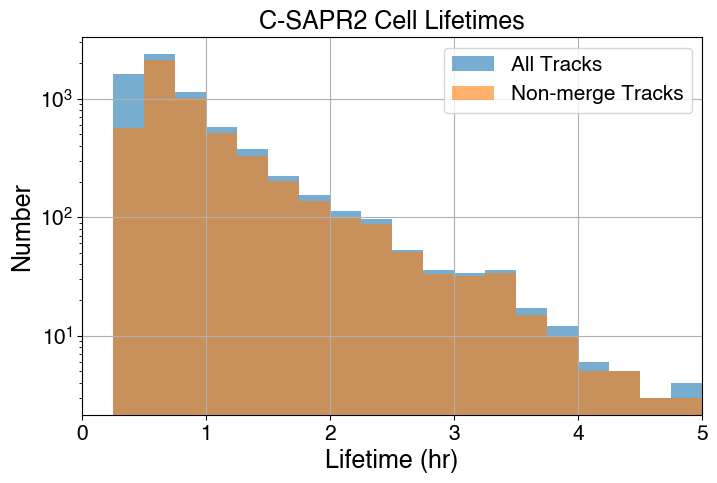

In [18]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Lifetime (hr)', fontsize=18)
ax1.set_ylabel('Number', fontsize=18)
ax1.hist(lifetime, bins=np.arange(21)*0.25, density=False, label='All Tracks', alpha=0.6)
ax1.hist(lifetime.isel(tracks=nonmerge), bins=np.arange(21)*0.25, density=False, label='Non-merge Tracks', alpha=0.6)
ax1.legend()
ax1.set_xlim(0, 5)
ax1.set_title('C-SAPR2 Cell Lifetimes', fontsize=18)
ax1.grid()
ax1.set_yscale('log')

# plt.hist(lifetime, bins=np.arange(21)*0.25)

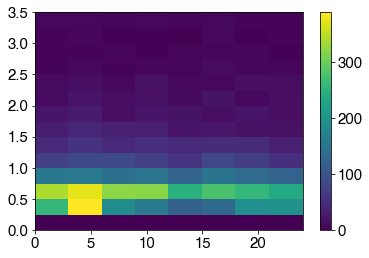

In [19]:
lt_bins = np.arange(15)*0.25
hour_bins = np.arange(9)*3
plt.hist2d(start_hour, lifetime, bins=[hour_bins, lt_bins], density=False)
plt.colorbar()

In [20]:
# #histograms
# plt.rcParams.update({'font.size': 14})

# start_hour = start_time.dt.hour
# end_hour = end_time.dt.hour

# fig = plt.figure(figsize=(16.5,7.))
# ax1 = fig.add_subplot(1,2,1)
# ax1.set_xlabel('Start Hour (UTC)', fontsize=18)
# ax1.set_ylabel('Number', fontsize=18)
# ax1.hist(start_hour, bins=np.arange(25), density=False)
# ax1.set_xlim(0, 24)
# ax1.set_title('C-SAPR2 Cell Track Start Times', fontsize=18)
# ax1.grid()
# ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlabel('End Hour (UTC)', fontsize=18)
# ax2.set_ylabel('Number', fontsize=18)
# ax2.hist(end_hour, bins=np.arange(25), density=False)
# ax2.set_xlim(0, 24)
# ax2.set_title('C-SAPR2 Cell Track End Times', fontsize=18)
# ax2.grid()
# fig.savefig('celltrack_startend_times.png')

In [21]:
# fig = plt.figure(figsize=(8.25,7.))
# ax1 = fig.add_subplot(1,1,1)
# ax1.set_xlabel('Lifetime (hr)', fontsize=18)
# ax1.set_ylabel('Number', fontsize=18)
# ax1.hist(lifetime, bins=np.arange(21)*0.25, density=False)
# ax1.set_xlim(0, 5)
# ax1.set_title('C-SAPR2 Cell Lifetimes', fontsize=18)
# ax1.grid()

In [22]:
# nonmerge = np.where(np.nan_to_num(end_merge_tracknumber) == 0)[0]
# nonsplit = np.where(np.nan_to_num(start_split_tracknumber) == 0)[0]

# fig = plt.figure(figsize=(16.5,7.))
# ax1 = fig.add_subplot(1,2,1)
# ax1.set_xlabel('Start Hour (UTC)', fontsize=18)
# ax1.set_ylabel('Number', fontsize=18)
# ax1.hist(start_hour[nonsplit], bins=np.arange(25), density=False)
# ax1.set_xlim(0, 24)
# ax1.set_title('C-SAPR2 Non-Split Cell Track Start Times', fontsize=18)
# ax1.grid()
# ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlabel('End Hour (UTC)', fontsize=18)
# ax2.set_ylabel('Number', fontsize=18)
# ax2.hist(end_hour[nonmerge], bins=np.arange(25), density=False)
# ax2.set_xlim(0, 24)
# ax2.set_title('C-SAPR2 Non-Merger Cell Track End Times', fontsize=18)
# ax2.grid()

In [23]:
# start_lon=np.empty(6857)
# start_lat=np.empty(6857)
# end_lon=np.empty(6857)
# end_lat=np.empty(6857)

# max_area=np.empty(6857)
# max_eth10=np.empty(6857)
# max_eth20=np.empty(6857)
# max_eth30=np.empty(6857)
# max_eth40=np.empty(6857)
# max_eth50=np.empty(6857)

# for i in np.arange(6857):
#     tmp1 = cell_lon[i,:]   
#     ind1 = np.where(tmp1 < -60)
#     tmp2 = cell_lat[i,:]
#     ind2 = np.where(tmp2 < -30)

#     start_lon[i] = tmp1[0]
#     start_lat[i] = tmp2[0]
#     end_lon[i] = tmp1[np.max(ind1)]
#     end_lat[i] = tmp2[np.max(ind2)]
#     max_area[i] = np.nanmax(cell_area[i,:])
#     max_eth10[i] = np.nanmax(eth10[i,:])
#     max_eth20[i] = np.nanmax(eth20[i,:])
#     max_eth30[i] = np.nanmax(eth30[i,:])
#     max_eth40[i] = np.nanmax(eth40[i,:])
#     max_eth50[i] = np.nanmax(eth50[i,:])

In [24]:
def plot_2heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, titles, figname):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]
    
    cmap = plt.get_cmap(cmap)
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

    ax1 = axes[0]
    Zm = np.ma.masked_where(dataarr[0] == 0, dataarr[0])
    p1 = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p1, ax=ax1)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(titles[0], loc='left')
    ax1.set_xlim(np.min(lonarr), np.max(lonarr))
    ax1.set_ylim(np.min(latarr), np.max(latarr))
    ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
    ax1.set_yticks(np.arange(-33, maxlat, 0.5))
    ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax1.plot(radar_lon, radar_lat, **marker_style)
    ax1.grid(ls='--')

    ax2 = axes[1]
    Zm = np.ma.masked_where(dataarr[1] == 0, dataarr[1])
    p2 = ax2.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p2, ax=ax2)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')
    ax2.set_title(titles[1], loc='left')
    ax2.set_xlim(np.min(lonarr), np.max(lonarr))
    ax2.set_ylim(np.min(latarr), np.max(latarr))
    ax2.set_xticks(np.arange(-65.5, maxlon, 0.5))
    ax2.set_yticks(np.arange(-33, maxlat, 0.5))
    ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax2.plot(radar_lon, radar_lat, **marker_style)
    ax2.grid(ls='--')

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

In [25]:
# minlat, maxlat = np.min(topoLat.values), np.max(topoLat.values)
# minlon, maxlon = np.min(topoLon.values), np.max(topoLon.values)
# print(minlon, maxlon, minlat, maxlat)

In [26]:
buffer = 0.05
minlon, maxlon = np.nanmin([start_lon.values, end_lon])-buffer, np.nanmax([start_lon.values, end_lon])+buffer
minlat, maxlat = np.nanmin([start_lat.values, end_lat])-buffer, np.nanmax([start_lat.values, end_lat])+buffer
print(minlon, maxlon, minlat, maxlat)

-65.92886047363281 -63.51902694702149 -33.15405349731445 -31.09662742614746


In [27]:
bins = [24, 24]
ranges = [[minlon+buffer,maxlon-buffer], [minlat+buffer,maxlat-buffer]]

# lonbinsize = 0.15
# latbinsize = 0.14
# lon_nbin = 17
# lat_nbin = 16
# lonbins = np.arange(lon_nbin)*lonbinsize + minlon
# latbins = np.arange(lat_nbin)*latbinsize + minlat - 0.1
# bins = [lonbins, latbins]
# ranges = [[min(lonbins),max(lonbins)], [min(latbins),max(latbins)]]

hist2d_startloc, xbins, ybins = np.histogram2d(start_lon.values, start_lat.values, bins=bins, range=ranges)
hist2d_endloc, xbins, ybins = np.histogram2d(end_lon, end_lat, bins=bins, range=ranges)

hist2d_startloc = hist2d_startloc.transpose()
hist2d_endloc = hist2d_endloc.transpose()

In [28]:
hist2d_startloc_nonsplit, xbins, ybins = np.histogram2d(start_lon.values[nonsplit_in], start_lat.values[nonsplit_in], bins=bins, range=ranges)
hist2d_endloc_nonmerge, xbins, ybins = np.histogram2d(end_lon[nonmerge_in], end_lat[nonmerge_in], bins=bins, range=ranges)

hist2d_startloc_nonsplit = hist2d_startloc_nonsplit.transpose()
hist2d_endloc_nonmerge = hist2d_endloc_nonmerge.transpose()

In [29]:
hist2d_startloc_split, xbins, ybins = np.histogram2d(start_lon.values[split], start_lat.values[split], bins=bins, range=ranges)
hist2d_endloc_merge, xbins, ybins = np.histogram2d(end_lon[merge], end_lat[merge], bins=bins, range=ranges)

hist2d_startloc_split = hist2d_startloc_split.transpose()
hist2d_endloc_merge = hist2d_endloc_merge.transpose()

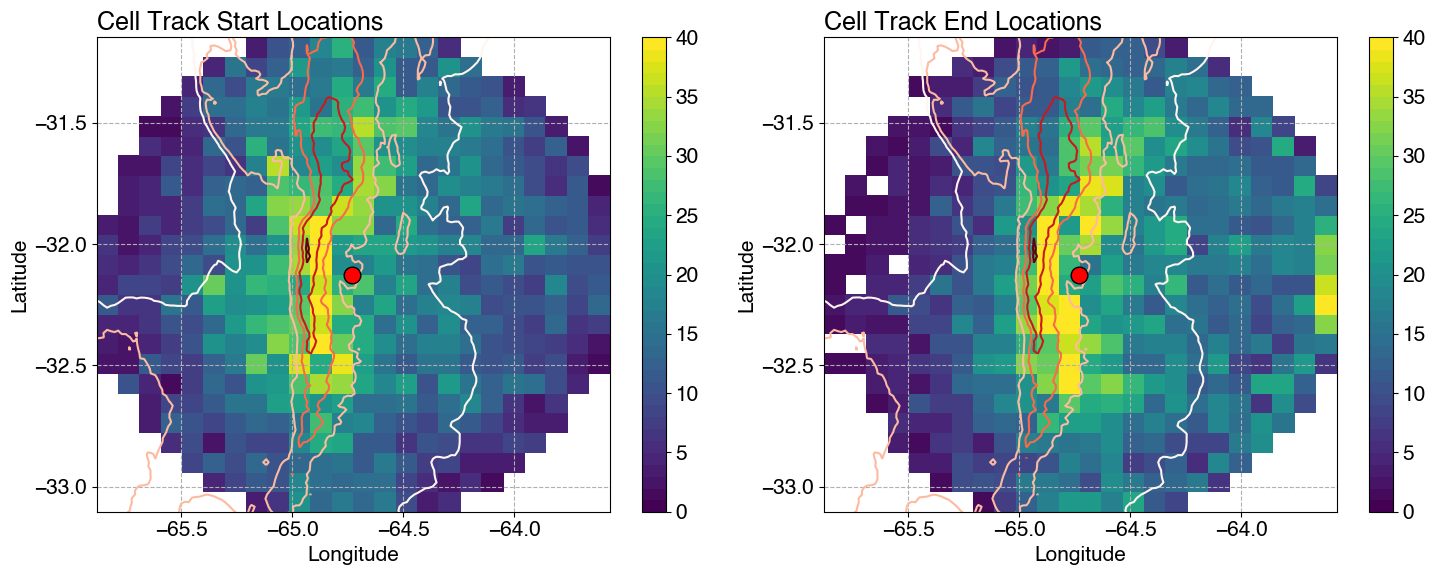

In [30]:
dataarr = [hist2d_startloc, hist2d_endloc]
levels = np.arange(0, 41, 1)
cmap = 'viridis'
cmap_topo = 'Reds'
titles = ['Cell Track Start Locations', 'Cell Track End Locations']
figname = f'{figdir}celltrack_startend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, titles, figname)

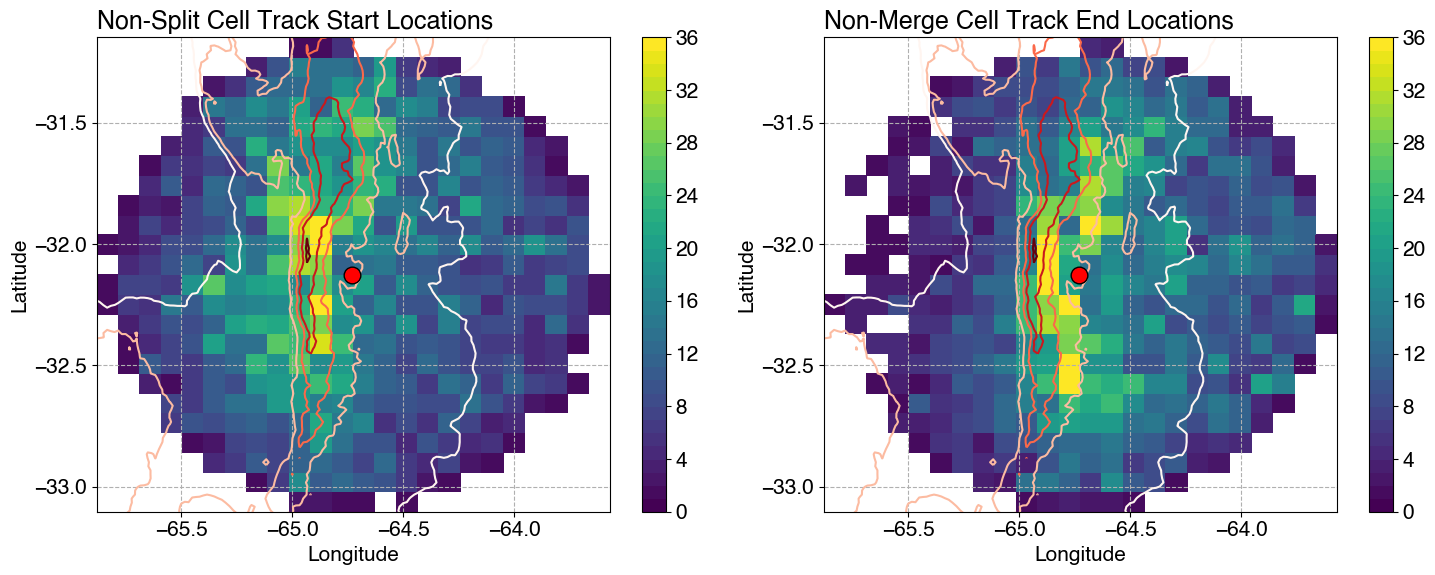

In [31]:
dataarr = [hist2d_startloc_nonsplit, hist2d_endloc_nonmerge]
levels = np.arange(0, 36.1, 1)
cmap = 'viridis'
cmap_topo = 'Reds'
titles = ['Non-Split Cell Track Start Locations', 'Non-Merge Cell Track End Locations']
figname = f'{figdir}celltrack_nonsplitstart_nonmergeend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, titles, figname)

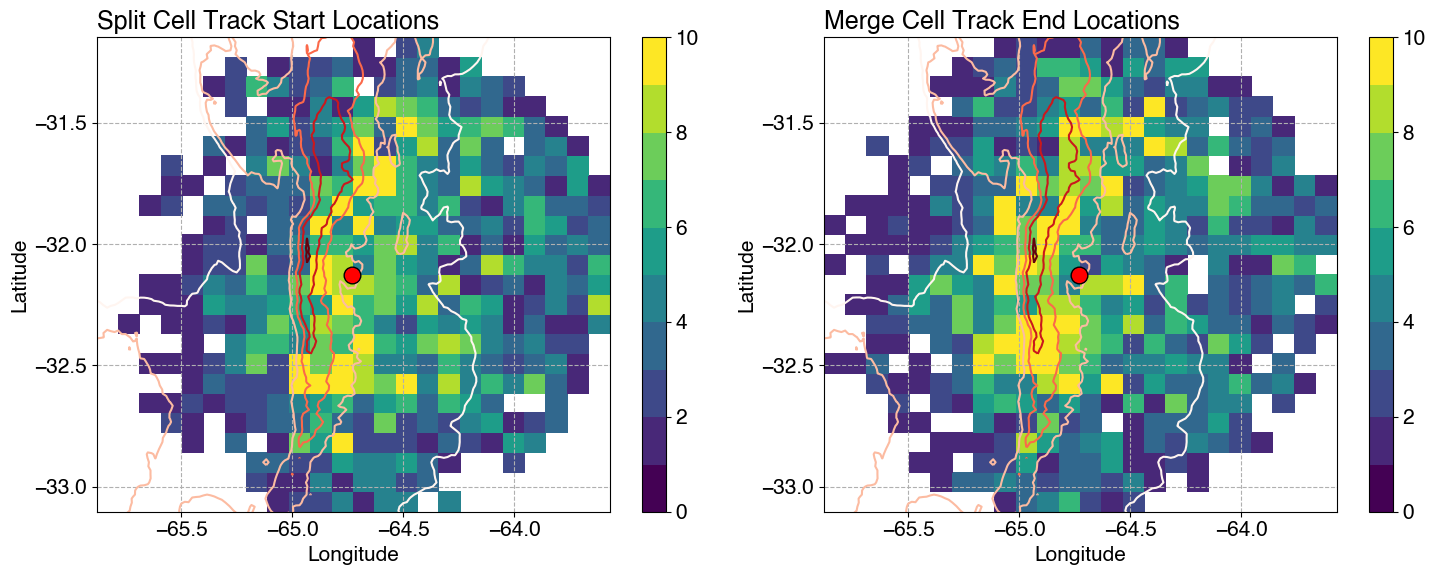

In [32]:
dataarr = [hist2d_startloc_split, hist2d_endloc_merge]
levels = np.arange(0, 11, 1)
cmap = 'viridis'
cmap_topo = 'Reds'
titles = ['Split Cell Track Start Locations', 'Merge Cell Track End Locations']
figname = f'{figdir}celltrack_splitstart_mergeend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, titles, figname)

In [33]:
shour_nonsplit = start_hour[nonsplit]
start_lon_nonsplit = start_lon.values[nonsplit]
start_lat_nonsplit = start_lat.values[nonsplit]

ehour_nonmerge = end_hour[nonmerge]
end_lon_nonmerge = end_lon[nonmerge]
end_lat_nonmerge = end_lat[nonmerge]

# Get track start hours [UTC]
mask0 = np.logical_and(shour_nonsplit >= 0, shour_nonsplit < 3)
mask3 = np.logical_and(shour_nonsplit >= 3, shour_nonsplit < 6)
mask6 = np.logical_and(shour_nonsplit >= 6, shour_nonsplit < 9)
mask9 = np.logical_and(shour_nonsplit >= 9, shour_nonsplit < 12)
mask12 = np.logical_and(shour_nonsplit >= 12, shour_nonsplit < 15)
mask15 = np.logical_and(shour_nonsplit >= 15, shour_nonsplit < 18)
mask18 = np.logical_and(shour_nonsplit >= 18, shour_nonsplit < 21)
mask21 = np.logical_and(shour_nonsplit >= 21, shour_nonsplit < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlon+buffer,maxlon-buffer], [minlat+buffer,maxlat-buffer]]
hist2d_startloc_nonsplit_hr0, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask0], start_lat_nonsplit[mask0], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr3, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask3], start_lat_nonsplit[mask3], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr6, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask6], start_lat_nonsplit[mask6], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr9, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask9], start_lat_nonsplit[mask9], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr12, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask12], start_lat_nonsplit[mask12], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr15, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask15], start_lat_nonsplit[mask15], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr18, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask18], start_lat_nonsplit[mask18], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr21, xbins_c, ybins_c = np.histogram2d(start_lon_nonsplit[mask21], start_lat_nonsplit[mask21], bins=bins, range=ranges)
# Transpose
hist2d_startloc_nonsplit_hr0 = hist2d_startloc_nonsplit_hr0.transpose()
hist2d_startloc_nonsplit_hr3 = hist2d_startloc_nonsplit_hr3.transpose()
hist2d_startloc_nonsplit_hr6 = hist2d_startloc_nonsplit_hr6.transpose()
hist2d_startloc_nonsplit_hr9 = hist2d_startloc_nonsplit_hr9.transpose()
hist2d_startloc_nonsplit_hr12 = hist2d_startloc_nonsplit_hr12.transpose()
hist2d_startloc_nonsplit_hr15 = hist2d_startloc_nonsplit_hr15.transpose()
hist2d_startloc_nonsplit_hr18 = hist2d_startloc_nonsplit_hr18.transpose()
hist2d_startloc_nonsplit_hr21 = hist2d_startloc_nonsplit_hr21.transpose()

In [34]:
hist2d_startloc_nonsplit_hr0.shape, xbins_c.shape, ybins_c.shape

((12, 12), (13,), (13,))

In [35]:
figdir

'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'

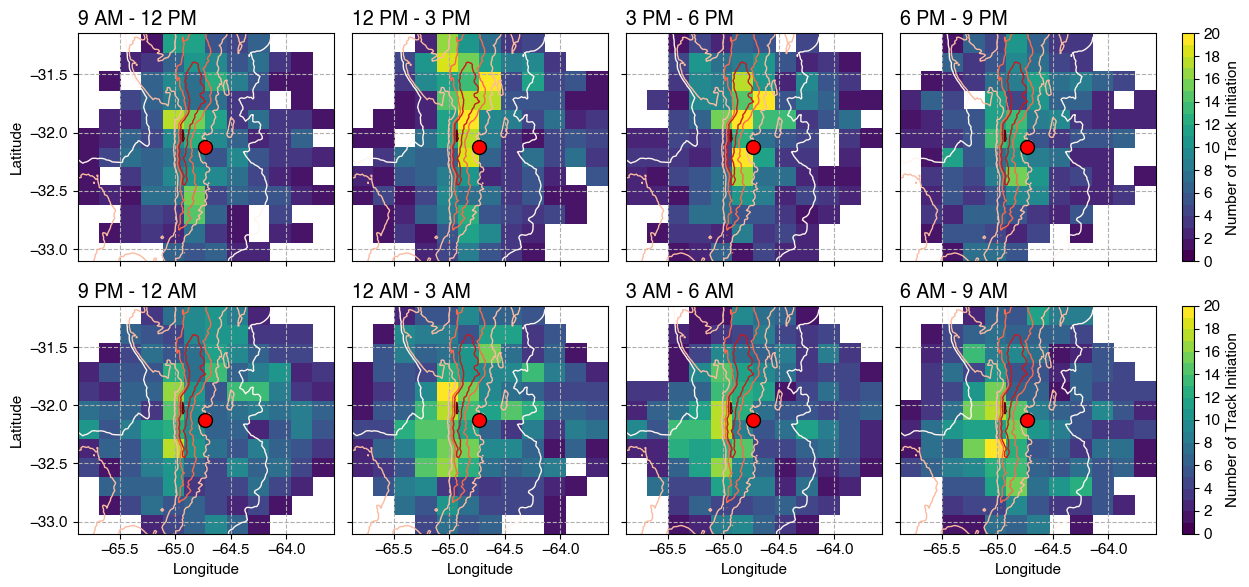

In [36]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=100)
   
dataarr = [[hist2d_startloc_nonsplit_hr12, hist2d_startloc_nonsplit_hr15, hist2d_startloc_nonsplit_hr18, hist2d_startloc_nonsplit_hr21],
           [hist2d_startloc_nonsplit_hr0, hist2d_startloc_nonsplit_hr3, hist2d_startloc_nonsplit_hr6, hist2d_startloc_nonsplit_hr9]]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
titles = [['9 AM - 12 PM', '12 PM - 3 PM', '3 PM - 6 PM', '6 PM - 9 PM'],
          ['9 PM - 12 AM', '12 AM - 3 AM', '3 AM - 6 AM', '6 AM - 9 AM']]
cblabel = 'Number of Track Initiation'

cmap = plt.get_cmap(cmap)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [500,1000,1500,2000,2500]

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='left', fontsize=14)
        ax1.set_xlim(np.min(lonarr), np.max(lonarr))
        ax1.set_ylim(np.min(latarr), np.max(latarr))
        ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
        ax1.set_yticks(np.arange(-33, maxlat, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        ax1.plot(radar_lon, radar_lat, **marker_style)
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 colorbar for each row
for row in range(2):
    cbar = fig.colorbar(pcm_save[row], ax=axs[row, :], shrink=1, pad=0.02, label=cblabel)
    cbar.set_ticks(cbticks)

fig.savefig(f'{figdir}celltrack_nonsplitstart_loc_diurnal_cycle_0.2deg_2x4.png', bbox_inches='tight', dpi=300)

In [37]:
xbins_c, ybins_c

(array([-65.87886047, -65.68637435, -65.49388822, -65.30140209,
        -65.10891596, -64.91642984, -64.72394371, -64.53145758,
        -64.33897146, -64.14648533, -63.9539992 , -63.76151307,
        -63.56902695]),
 array([-33.1040535 , -32.94093466, -32.77781582, -32.61469698,
        -32.45157814, -32.2884593 , -32.12534046, -31.96222162,
        -31.79910278, -31.63598394, -31.4728651 , -31.30974627,
        -31.14662743]))

In [38]:
xbins, ybins

(array([-65.87886047, -65.78261741, -65.68637435, -65.59013128,
        -65.49388822, -65.39764516, -65.30140209, -65.20515903,
        -65.10891596, -65.0126729 , -64.91642984, -64.82018677,
        -64.72394371, -64.62770065, -64.53145758, -64.43521452,
        -64.33897146, -64.24272839, -64.14648533, -64.05024227,
        -63.9539992 , -63.85775614, -63.76151307, -63.66527001,
        -63.56902695]),
 array([-33.1040535 , -33.02249408, -32.94093466, -32.85937524,
        -32.77781582, -32.6962564 , -32.61469698, -32.53313756,
        -32.45157814, -32.37001872, -32.2884593 , -32.20689988,
        -32.12534046, -32.04378104, -31.96222162, -31.8806622 ,
        -31.79910278, -31.71754336, -31.63598394, -31.55442452,
        -31.4728651 , -31.39130569, -31.30974627, -31.22818685,
        -31.14662743]))

In [39]:
def plot_4heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    
    fig, axes = plt.subplots(2, 2, figsize=(10,8), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]
    
    xlabels = [['Longitude','Longitude',], ['Longitude','Longitude']]
    ylabels = [['Latitude','Latitude',], ['Latitude','Latitude',]]

    for row in range(2):
        for col in range(2):
            ax1 = axes[row, col]
            cmap = plt.get_cmap(cmaps[row][col])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
            pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
            cb = plt.colorbar(pcm, ax=ax1, label=cblabels[row][col])
            cb.set_ticks(cbticks[row][col])
            ax1.set_xlim(np.min(lonarr), np.max(lonarr))
            ax1.set_ylim(np.min(latarr), np.max(latarr))
            ax1.set_xlabel(xlabels[row][col])
            ax1.set_ylabel(ylabels[row][col])
            ax1.set_title(titles[row][col], loc='left', fontsize=16)
            ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
            ax1.set_yticks(np.arange(-33, maxlat, 0.5))
            ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[row][col], linewidths=1.5)
            ax1.plot(radar_lon, radar_lat, **marker_style)
            ax1.grid(ls='--')
#             if (row == 0):
#                 ax1.xaxis.set_ticklabels([])
#             if (col > 0):
#                 ax1.yaxis.set_ticklabels([])

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

In [40]:
#heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lonbinsize = 0.2
latbinsize = 0.2
lon_nbin = 13
lat_nbin = 12
# lonbinsize = 0.15
# latbinsize = 0.14
# lon_nbin = 17
# lat_nbin = 16

# lonbins = np.arange(lon_nbin)*lonbinsize - 65.9
# latbins = np.arange(lat_nbin)*latbinsize - 33.1
lonbins = np.arange(lon_nbin)*lonbinsize + minlon
latbins = np.arange(lat_nbin)*latbinsize + minlat - 0.1
Mean_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat = np.array(cell_lon).flatten()
Lat_flat = np.array(cell_lat).flatten()
Area_flat = np.array(cell_area).flatten()
ETH10_flat = np.array(eth10).flatten()
ETH20_flat = np.array(eth20).flatten()
ETH30_flat = np.array(eth30).flatten()
ETH40_flat = np.array(eth40).flatten()
ETH50_flat = np.array(eth50).flatten()

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat >= lonbins[i], Lon_flat < lonbins[i]+lonbinsize),
                              Lat_flat >= latbins[j]), Lat_flat < latbins[j]+latbinsize), Area_flat > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Area_heatmap[j,i] = np.nanmean(Area_flat[mask])
            Median_Area_heatmap[j,i] = np.nanmedian(Area_flat[mask])
            Max_Area_heatmap[j,i] = np.nanmax(Area_flat[mask])
            Mean_ETH10_heatmap[j,i] = np.nanmean(ETH10_flat[mask])
            Median_ETH10_heatmap[j,i] = np.nanmedian(ETH10_flat[mask])
            Max_ETH10_heatmap[j,i] = np.nanmax(ETH10_flat[mask])
            Mean_ETH20_heatmap[j,i] = np.nanmean(ETH20_flat[mask])
            Median_ETH20_heatmap[j,i] = np.nanmedian(ETH20_flat[mask])
            Max_ETH20_heatmap[j,i] = np.nanmax(ETH20_flat[mask])
            Mean_ETH30_heatmap[j,i] = np.nanmean(ETH30_flat[mask])
            Median_ETH30_heatmap[j,i] = np.nanmedian(ETH30_flat[mask])
            Max_ETH30_heatmap[j,i] = np.nanmax(ETH30_flat[mask])
            Mean_ETH40_heatmap[j,i] = np.nanmean(ETH40_flat[mask])
            Median_ETH40_heatmap[j,i] = np.nanmedian(ETH40_flat[mask])
            Max_ETH40_heatmap[j,i] = np.nanmax(ETH40_flat[mask])
            Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
            Median_ETH50_heatmap[j,i] = np.nanmedian(ETH50_flat[mask])
            Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])

/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater_equal
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater_equal
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in less
/home/zhe1feng1/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


In [41]:
# lonbins, minlon, maxlon

In [42]:
# latbins, minlat, maxlat

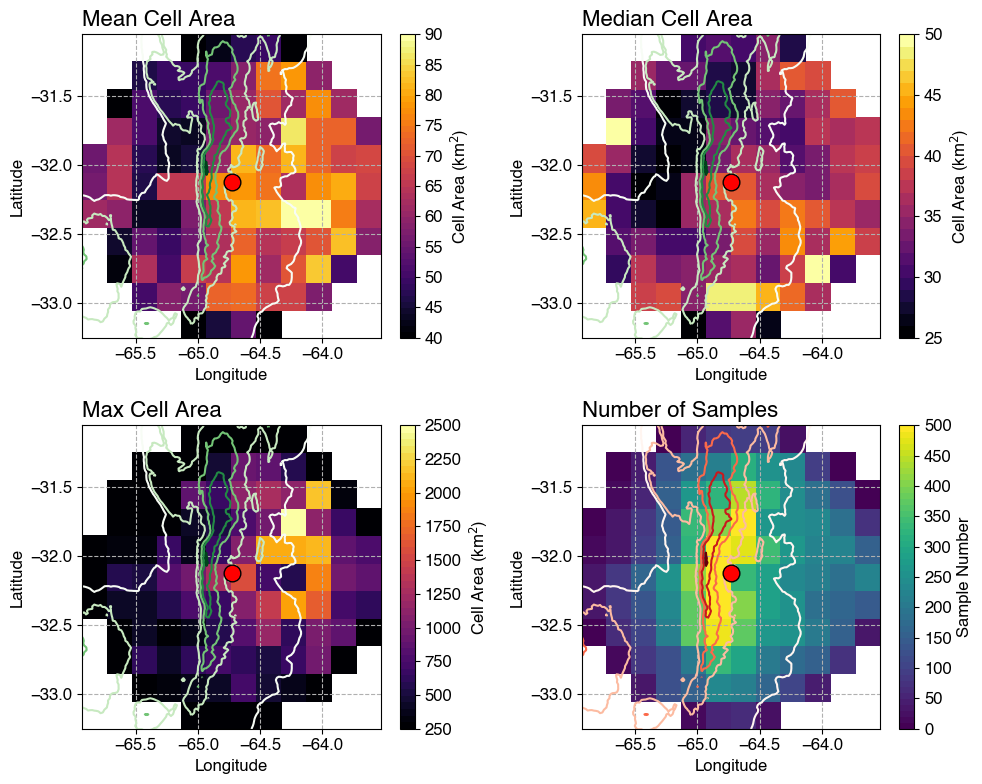

In [43]:
dataarr = [[Mean_Area_heatmap, Median_Area_heatmap],
           [Max_Area_heatmap, Samples_heatmap]]
levels = [[np.arange(40, 90.1, 1), np.arange(25, 50.1, 1)], 
          [np.arange(250, 2501, 50), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(40, 90.1, 5), np.arange(25, 50.1, 5)], 
           [np.arange(250, 2500.1, 250), np.arange(0, 500.1, 50)]]
# cmaps = [['plasma', 'plasma'], 
#          ['plasma', 'viridis']]
cmaps = [['inferno', 'inferno'], 
         ['inferno', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell Area', 'Median Cell Area'],
          ['Max Cell Area', 'Number of Samples']]
cblabels = [['Cell Area (km$^{2}$)', 'Cell Area (km$^{2}$)'],
            ['Cell Area (km$^{2}$)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_area_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

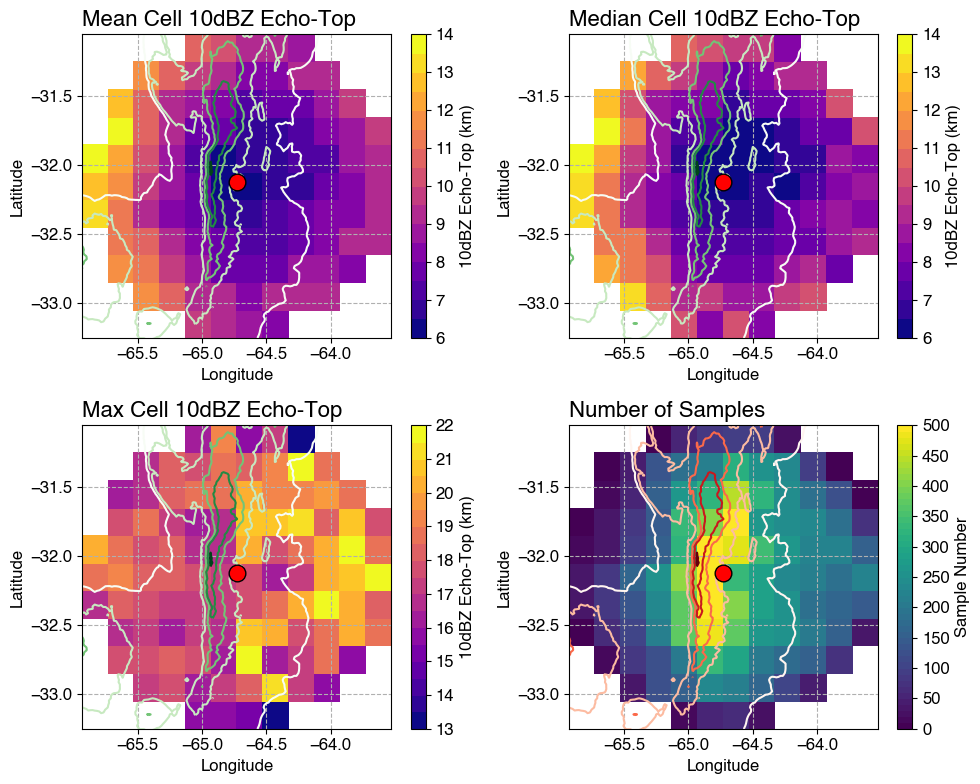

In [44]:
dataarr = [[Mean_ETH10_heatmap, Median_ETH10_heatmap],
           [Max_ETH10_heatmap, Samples_heatmap]]
levels = [[np.arange(6, 14.1, 0.5), np.arange(6, 14.1, 0.5)], 
          [np.arange(13, 22.1, 0.5), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(6, 14.1, 1), np.arange(6, 14.1, 1)], 
          [np.arange(13, 22.1, 1), np.arange(0, 500.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 10dBZ Echo-Top', 'Median Cell 10dBZ Echo-Top'],
          ['Max Cell 10dBZ Echo-Top', 'Number of Samples']]
cblabels = [['10dBZ Echo-Top (km)', '10dBZ Echo-Top (km)'],
            ['10dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_10dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

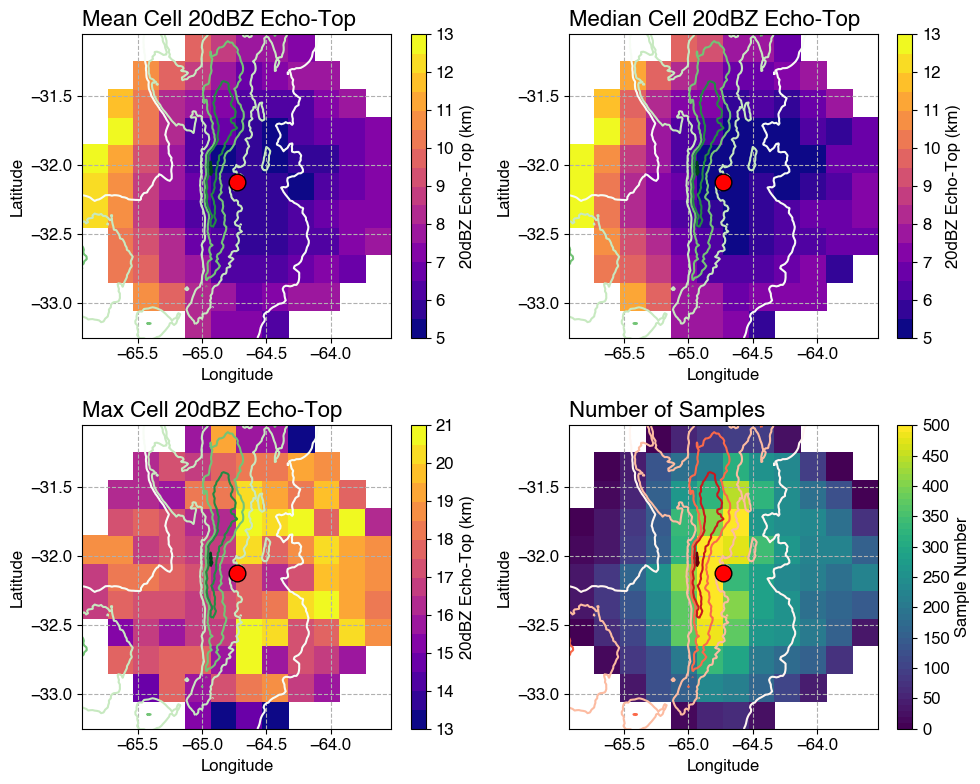

In [45]:
dataarr = [[Mean_ETH20_heatmap, Median_ETH20_heatmap],
           [Max_ETH20_heatmap, Samples_heatmap]]
levels = [[np.arange(5, 13.1, 0.5), np.arange(5, 13.1, 0.5)], 
          [np.arange(13, 21.1, 0.5), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(5, 13.1, 1), np.arange(5, 13.1, 1)], 
          [np.arange(13, 21.1, 1), np.arange(0, 500.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 20dBZ Echo-Top', 'Median Cell 20dBZ Echo-Top'],
          ['Max Cell 20dBZ Echo-Top', 'Number of Samples']]
cblabels = [['20dBZ Echo-Top (km)', '20dBZ Echo-Top (km)'],
            ['20dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_20dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

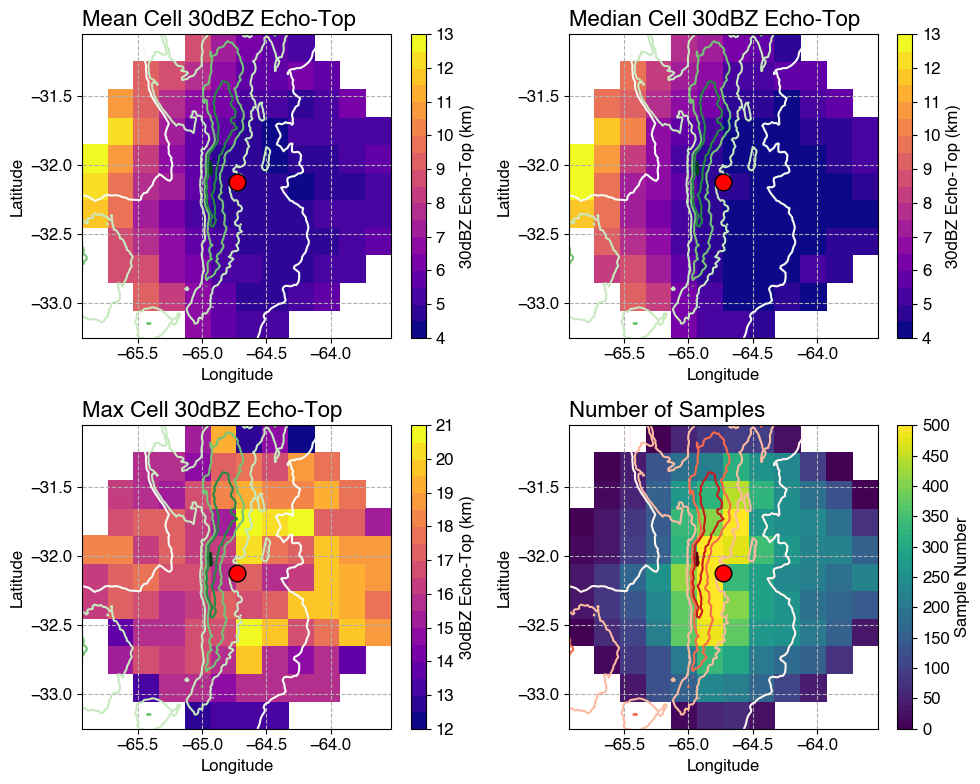

In [49]:
dataarr = [[Mean_ETH30_heatmap, Median_ETH30_heatmap],
           [Max_ETH30_heatmap, Samples_heatmap]]
levels = [[np.arange(4, 13.1, 0.5), np.arange(4, 13.1, 0.5)], 
          [np.arange(12, 21.01, 0.5), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(4, 13.1, 1), np.arange(4, 13.1, 1)], 
          [np.arange(12, 21.1, 1), np.arange(0, 500.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 30dBZ Echo-Top', 'Median Cell 30dBZ Echo-Top'],
          ['Max Cell 30dBZ Echo-Top', 'Number of Samples']]
cblabels = [['30dBZ Echo-Top (km)', '30dBZ Echo-Top (km)'],
            ['30dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_30dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

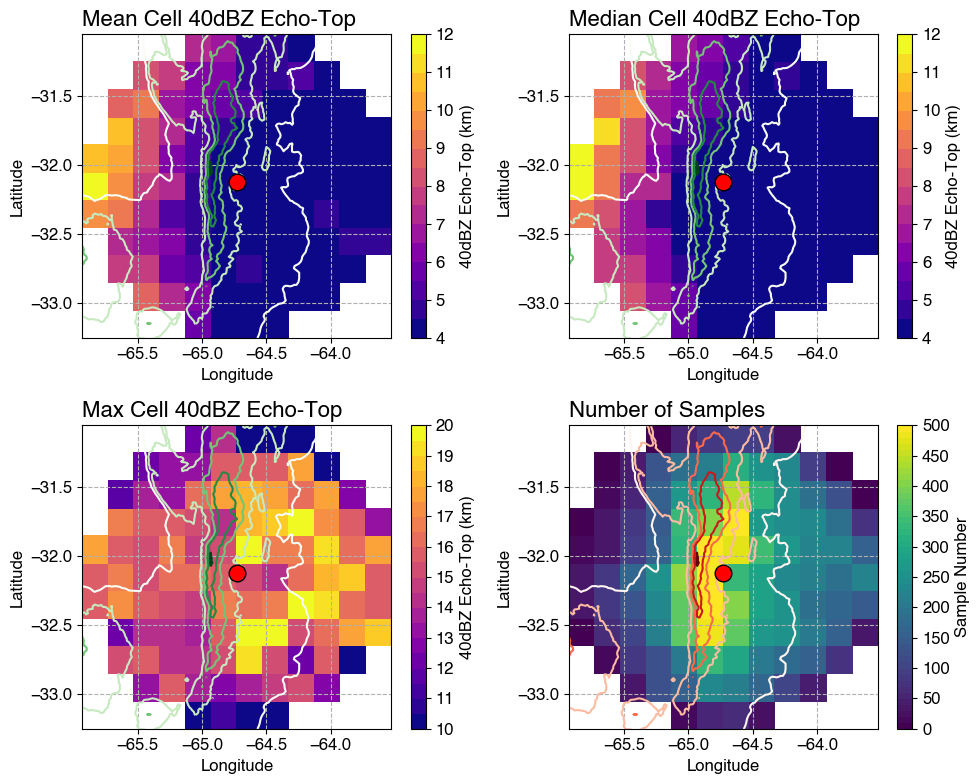

In [50]:
dataarr = [[Mean_ETH40_heatmap, Median_ETH40_heatmap],
           [Max_ETH40_heatmap, Samples_heatmap]]
levels = [[np.arange(4, 12.1, 0.5), np.arange(4, 12.1, 0.5)], 
          [np.arange(10, 20.01, 0.5), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(4, 12.1, 1), np.arange(4, 12.1, 1)], 
          [np.arange(10, 20.1, 1), np.arange(0, 500.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 40dBZ Echo-Top', 'Median Cell 40dBZ Echo-Top'],
          ['Max Cell 40dBZ Echo-Top', 'Number of Samples']]
cblabels = [['40dBZ Echo-Top (km)', '40dBZ Echo-Top (km)'],
            ['40dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_40dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

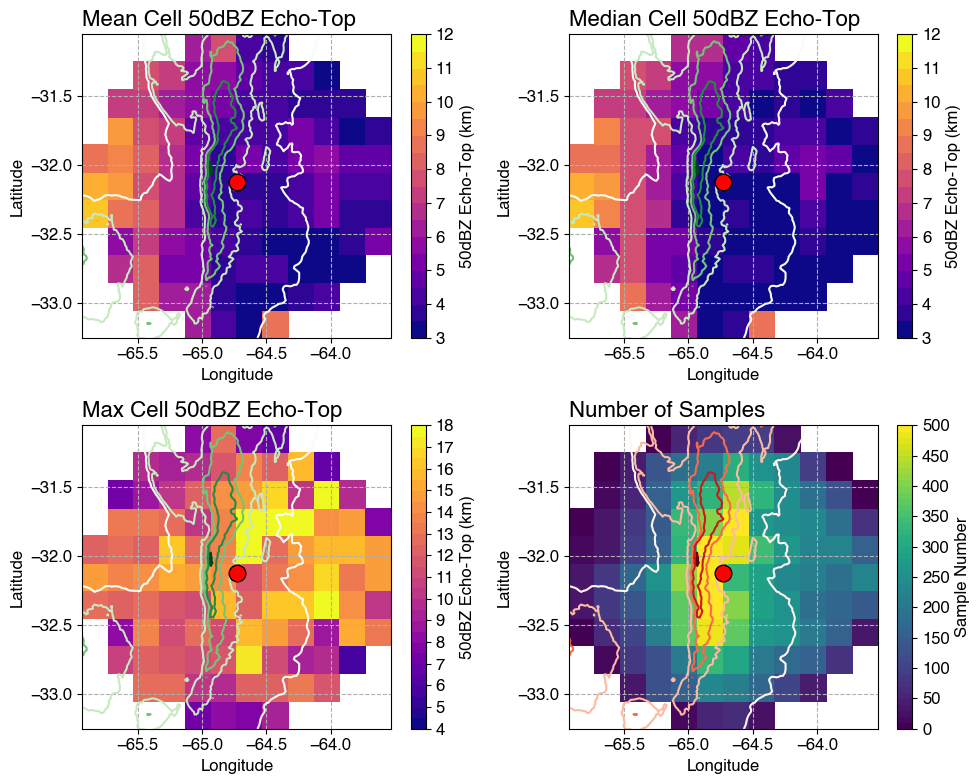

In [51]:
dataarr = [[Mean_ETH50_heatmap, Median_ETH50_heatmap],
           [Max_ETH50_heatmap, Samples_heatmap]]
levels = [[np.arange(3, 12.1, 0.5), np.arange(3, 12.1, 0.5)], 
          [np.arange(4, 18.01, 0.5), np.arange(0, 500.1, 10)]]
cbticks = [[np.arange(3, 12.1, 1), np.arange(3, 12.1, 1)], 
          [np.arange(4, 18.01, 1), np.arange(0, 500.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 50dBZ Echo-Top', 'Median Cell 50dBZ Echo-Top'],
          ['Max Cell 50dBZ Echo-Top', 'Number of Samples']]
cblabels = [['50dBZ Echo-Top (km)', '50dBZ Echo-Top (km)'],
            ['50dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_50dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

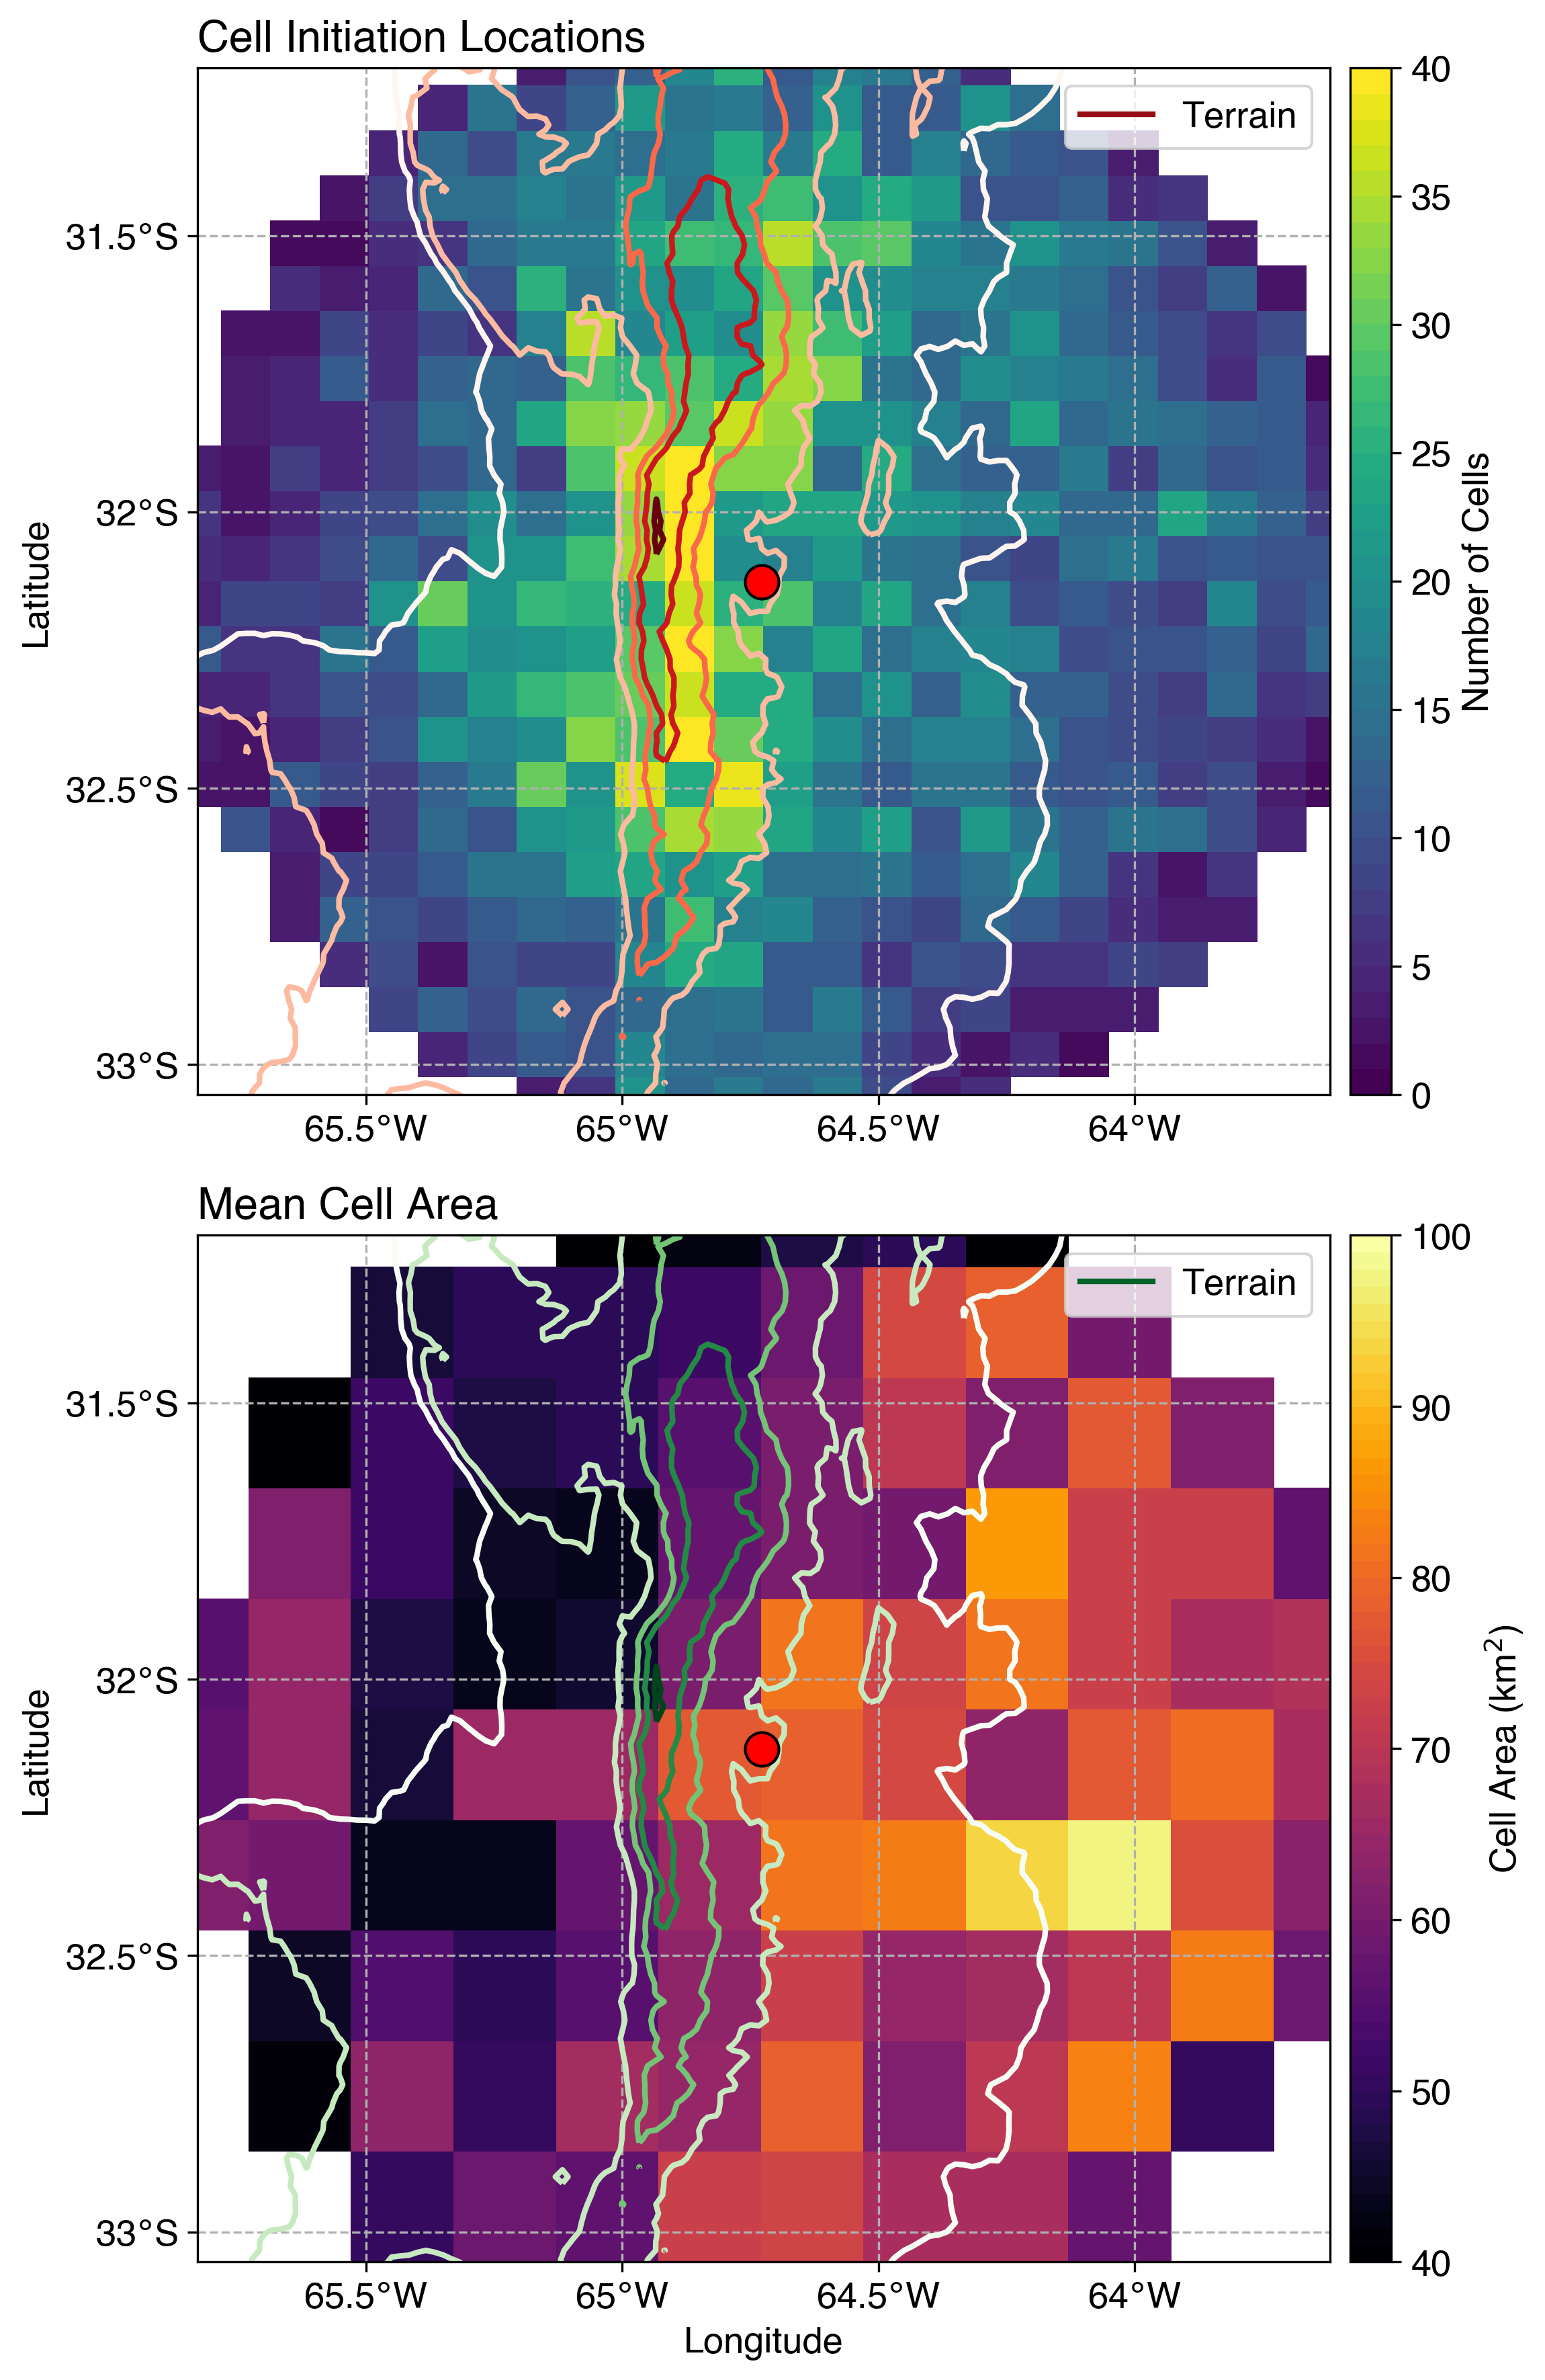

In [52]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(2, 1, figsize=(8,12), dpi=300)
marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
topo_levs = [500,1000,1500,2000,2500]


xlims = [np.min(lonarr)+0.05, np.max(lonarr)-0.05]
ylims = [np.min(latarr)+0.05, np.max(latarr)-0.05]
xticklabels = [r'65.5$\degree$W',r'65$\degree$W',r'64.5$\degree$W',r'64$\degree$W',]
yticklabels = [r'33$\degree$S',r'32.5$\degree$S',r'32$\degree$S',r'31.5$\degree$S']

cmap_topo = 'Reds'
cmap = plt.get_cmap('viridis')
levels = np.arange(0, 40.1, 1)
cbticks = np.arange(0, 40.1, 5)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

ax1 = axes[0]
# Zm = np.ma.masked_where(hist2d_startloc_nonsplit == 0, hist2d_startloc_nonsplit)
Zm = np.ma.masked_where(hist2d_startloc == 0, hist2d_startloc)
p1 = ax1.pcolormesh(xbins, ybins, Zm, norm=norm, cmap=cmap)
cb = plt.colorbar(p1, ax=ax1, label='Number of Cells', pad=0.015, aspect=25)
# ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Cell Initiation Locations', loc='left')
ax1.set_xlim(xlims[0], xlims[1])
ax1.set_ylim(ylims[0], ylims[1])
ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
ax1.set_yticks(np.arange(-33, maxlat, 0.5))
ax1.set_xticklabels(xticklabels)
ax1.set_yticklabels(yticklabels)
ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=2)
ax1.plot(radar_lon, radar_lat, **marker_style)
ax1.grid(ls='--')
# Legend for terrain
custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.9), lw=2)]
ax1.legend(custom_lines, ['Terrain'], loc='upper right')


cmap_topo = 'Greens'
cmap = plt.get_cmap('inferno')
levels = np.arange(40, 100.1, 1)
cbticks = np.arange(40, 100.1, 10)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

ax2 = axes[1]
Zm = np.ma.masked_where((Mean_Area_heatmap == 0) | (Samples_heatmap < 10), Mean_Area_heatmap)
p2 = ax2.pcolormesh(lonbins, latbins, Zm, norm=norm, cmap=cmap)
cb = plt.colorbar(p2, ax=ax2, label='Cell Area (km$^{2}$)', ticks=cbticks, pad=0.015, aspect=25)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Mean Cell Area', loc='left')
ax2.set_xlim(xlims[0], xlims[1])
ax2.set_ylim(ylims[0], ylims[1])
ax2.set_xticks(np.arange(-65.5, maxlon, 0.5))
ax2.set_yticks(np.arange(-33, maxlat, 0.5))
ax2.set_xticklabels(xticklabels)
ax2.set_yticklabels(yticklabels)
ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=2)
ax2.plot(radar_lon, radar_lat, **marker_style)
ax2.grid(ls='--')
# Legend for terrain
custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.9), lw=2)]
ax2.legend(custom_lines, ['Terrain'], loc='upper right')

fig.tight_layout()
canvas = FigureCanvas(fig)
figname = f'{figdir}celltrack_startloc_meanarea_4BAMS.png'
canvas.print_png(figname)
# fig.savefig(figname)
fig.savefig(f'{figdir}celltrack_startloc_meanarea_4BAMS.png', bbox_inches='tight', dpi=300)

In [53]:
figdir

'/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'